Image Recognition
===

This notebook will create a convolutional neural network to classify images in either the mnist or cifar-10 datasets.

In [3]:
# Tensorflow and numpy to create the neural network
import tensorflow as tf
import numpy as np

# Matplotlib to plot info to show our results
import matplotlib.pyplot as plt

# OS to load files and save checkpoints
import os

%matplotlib inline

Loading the data
---

This code will load the dataset that you'll use to train and test the model.

The code provided will load the mnist or cifar data from files, you'll need to add the code that processes it into a format your neural network can use.

MNIST
---

Run this cell to load mnist data.

In [5]:
# Load MNIST data from tf examples

image_height = 28
image_width = 28

color_channels = 1

model_name = "mnist"

mnist = tf.contrib.learn.datasets.load_dataset("mnist")

train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

category_names = list(map(str, range(10)))

# ======================== #
# TODO: Process mnist data #
# ======================== #
# Will Print (55000, 784) List of 55,000 lists of 784 pixels per image
print(train_data.shape) 

# Neural network will need the 784 pixels to be in a multi-dimensional list
# -1 infers the shape for proceeding inputs
train_data = np.reshape(train_data, (-1, image_height, image_width, color_channels))

# Should print (55000, 28, 28, 1)
print(train_data.shape)

eval_data = np.reshape(eval_data, (-1, image_height, image_width, color_channels))

Extracting MNIST-data\train-images-idx3-ubyte.gz


Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


(55000, 784)
(55000, 28, 28, 1)


CIFAR-10
---

Run this cell to load cifar-10 data

In [4]:
# Load cifar data from file
# NOTE each image in CIFAR-10 Data set is 32x32 with 3 colour channels 
# total of 3072 inputs

image_height = 32
image_width = 32

color_channels = 3

model_name = "cifar"

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_path = './cifar-10-data/'



# Load the english category names.
category_names_bytes = unpickle(cifar_path + 'batches.meta')[b'label_names']
category_names = list(map(lambda x: x.decode("utf-8"), category_names_bytes))

# ======================== #
# TODO: Process Cifar data #
# ======================== #

# Function that processes data from 0 to 255 TO 0 to 1.0
# Data is organized in RGB values i.e. [ r1 , b1 , g1] 
def process_data(data):
    # Converts Array to floats & changes values to 0.0 or 1.0
    float_data = np.array(data, dtype=np.float32) / 255.0
    
    # same as MNIST reshapes data in multi-dimensional to be fed to neural network
    reshaped_data = np.reshape(float_data, (-1, color_channels, image_height, image_width))
     
    # sorts RGB values to show a clearer picture
    transposed_data = np.transpose(reshaped_data, [0, 2, 3, 1])
    # returns transposed data of image
    return transposed_data

# =========================================== #

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


train_filename = "cifar-10-data/train.tfrecords"

if not os.path.isfile(train_filename):
    # If training data isn't rfrecorded yet, do so.
    
    train_data = np.array([])
    train_labels = np.array([], dtype=np.int64)
    
    # Load all the data batches.
    for i in range(1,6):
        data_batch = unpickle(cifar_path + 'data_batch_' + str(i))
        train_data = np.append(train_data, data_batch[b'data'])
        train_labels = np.append(train_labels, data_batch[b'labels'])
    
    writer = tf.python_io.TFRecordWriter(train_filename)
    
    train_data = process_data(train_data)
    
    for index in range(len(train_data)):
        feature = {'image': _bytes_feature(tf.compat.as_bytes(train_data[index].tostring())),
                   'label': _int64_feature(train_labels[index])}
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        writer.write(example.SerializeToString())
    
    writer.close()
    print("Training data generated in " + train_filename)


# Load the eval batch.
eval_batch = unpickle(cifar_path + 'test_batch')

eval_data = eval_batch[b'data']
eval_labels = eval_batch[b'labels'] 

eval_data = process_data(eval_data)

# Function to parse a training tfrecord
def parse_cifar_record(record):
    features = tf.parse_single_example(
        record,
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })
    image = tf.decode_raw(features['image'], tf.float32)
    image.set_shape([color_channels * image_height * image_width])
    image = tf.reshape(image, [image_height, image_width, color_channels])
    label = tf.cast(features['label'], tf.float32)
    
    return image, label

Once the data is processed, you have a few variables for the data itself and info about its shape:

### Model Info

- **image_height, image_width** - The height and width of the processed images
- **color_channels** - the number of color channels in the image. This will be either 1 for grayscale or 3 for rgb.
- **model_name** - either "cifar" or "mnist" - if you need to handle anything differently based on the model, check this variable.
- **category_names** - strings for each category name (used to print out labels when testing results)

### Training Data

- **train_data** - the training data images
- **train_labels** - the labels for the training data - the "answer key"

### Evaluation Data

- **eval_data** - Image data for evaluation. A different set of images to test your network's effectiveness.
- **eval_labels** - the answer key for evaluation data.

Building the Neural Network Model
--

Next, you'll build a neural network with the following architecture:

- An input placeholder that takes one or more images.
- 1st Convolutional layer with 32 filters and a kernel size of 5x5 and same padding
- 1st Pooling layer with a 2x2 pool size and stride of 2
- 2nd Convolutional layer with 64 filters and a kernel size of 5x5 and same padding
- 2nd Pooling layer with a 2x2 pool size and stride of 2
- Flatten the pooling layer
- A fully connected layer with 1024 units
- A dropout layer with a rate of 0.4
- An output layer with an output size equal to the number of labels.

In [7]:
# Class declaration
class ConvNet:
    # Constructor
    # This will setup the CNN
    def __init__(self, image_height, image_width, channels, num_classes):
        # First layer is just for processing the inputs
        self.input_layer = tf.placeholder(dtype=tf.float32,
                                          shape=[None, image_height, image_width, channels],
                                          name="inputs")
        # Show the shape of the input layer
        print(self.input_layer.shape)
        
        # Creating the first of the convolution layers
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=64, kernel_size=[3, 3],
                                        padding="same", activation=tf.nn.relu)
        print(conv_layer_1.shape)
        
        # Creating the first pooling layer
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2, 2], strides=2)
        print(pooling_layer_1.shape)
        
        # Creating the second of the convolution layers
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters=128, kernel_size=[3, 3],
                                        padding="same", activation=tf.nn.relu)
        print(conv_layer_2.shape)
        
        # Creating the second pooling layer
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        print(pooling_layer_2.shape)       
        
        # Flatten all layers
        flattened_pooling = tf.layers.flatten(pooling_layer_2)
        
        # Make it dense
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        
        # Add some randomness to the NN
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training=True)
        print(dropout.shape)
        
        # Final layer
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
        
        self.choice = tf.argmax(outputs, axis=1)
        self.probability = tf.nn.softmax(outputs)
        
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
        
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=5e-2)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())

The Training Process
---

The cells below will set up and run the training process.

- Set up initial values for batch size, training length.
- Process data into batched datasets to feed into the network.
- Run through batches of training data, update weights, save checkpoints.

In [16]:
# How long to train
training_steps = 2000
# Number of images to be passed
batch_size = 32

path = "./" + model_name + "-cnn/"

load_checkpoint = True
print(load_checkpoint)
performance_graph = np.array([])

True


In [26]:
tf.reset_default_graph()

if model_name == "mnist":
    dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    dataset = dataset.shuffle(buffer_size=train_labels.shape[0])
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
else:
    filenames = ["cifar-10-data/train.tfrecords"]
    dataset = tf.data.TFRecordDataset(filenames).repeat()
    dataset = dataset.map(parse_cifar_record)
    dataset = dataset.shuffle(buffer_size=45000)
    dataset = dataset.batch(batch_size)
    
dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()

# Create an instance of the CNN
cnn = ConvNet(image_height, image_width, color_channels, 10)
# Save a checkpoint
saver = tf.train.Saver(max_to_keep=2)
# Create a folder to store our Checkpoints
if not os.path.exists(path):
    os.makedirs(path)
    
# Get ready for training
print("Training started")
with tf.Session() as sess:
    # Initial weights
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    
    # Training loop
    for step in range(training_steps):
        current_batch = sess.run(next_element)
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
        
        # Run the network training operation
        sess.run((cnn.train_operation, cnn.accuracy_op),
                 feed_dict={cnn.input_layer: batch_inputs, cnn.labels: batch_labels})
        
        if step % 10 == 0:
            performance_graph = np.append(performance_graph, sess.run(cnn.accuracy))
        
        if step % 1000 == 0 and step > 0:
            current_acc = sess.run(cnn.accuracy)
            print("Accuracy at step " + str(step) + ": " + str(current_acc))
            print("Saving checkpoint")
            saver.save(sess, path + model_name, step)
            
    # End of loop stuff
    current_acc = sess.run(cnn.accuracy)
    print("Final accuracy " + str(current_acc))
    print("Saving final checkpoint for training session")
    saver.save(sess, path + model_name, step)

(?, 28, 28, 1)
(?, 28, 28, 64)
(?, 14, 14, 64)
(?, 14, 14, 128)
(?, 7, 7, 128)
(?, 1024)
(?, 1024)
(?, 10)


Training started
INFO:tensorflow:Restoring parameters from ./mnist-cnn/mnist-1999


Accuracy at step 1000: 0.9922577
Saving checkpoint


Final accuracy 0.9920928
Saving final checkpoint for training session


Evaluating Performance
---

These cells will evaluate the performance of your network!

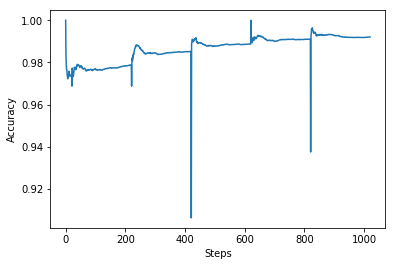

In [27]:
plt.figure().set_facecolor('white')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.plot(performance_graph)

In [28]:
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    sess.run(tf.local_variables_initializer())
    
    for image, label in zip(eval_data, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer: [image], cnn.labels: label})
    
    print(sess.run(cnn.accuracy))

INFO:tensorflow:Restoring parameters from ./mnist-cnn/mnist-1999


0.9896


INFO:tensorflow:Restoring parameters from ./mnist-cnn/mnist-1999


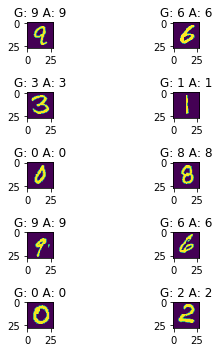

In [29]:
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    indexes = np.random.choice(len(eval_data), 10, replace=False)
    
    rows = 5
    cols = 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(5,5))
    fig.patch.set_facecolor('white')
    image_count = 0
    
    for idx in indexes:
        image_count += 1
        sub = plt.subplot(rows,cols,image_count)
        img = eval_data[idx]
        if model_name == "mnist":
            img = img.reshape(28, 28)
        plt.imshow(img)
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[eval_data[idx]]})
        if model_name == "mnist":
            guess_name = str(guess[0])
            actual_name = str(eval_labels[idx])
        else:
            guess_name = category_names[guess[0]]
            actual_name = category_names[eval_labels[idx]]
        sub.set_title("G: " + guess_name + " A: " + actual_name)
    plt.tight_layout()
